# Lab 5: Species Distribution Modeling with Bagging 
Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [2]:
# Assign csv to dat variable
dat = pd.read_csv("BirdTraitData.csv", encoding="ISO-8859-1")

In [3]:
# Explore dat characteristics
pd.set_option('display.max_columns', None)
dat.head(1)

,Order,Family,Genus,Species,Authority,CommonName,AdultBodyMass,DietBreadth,Diet: invertebrates,Diet: vertebrates,Diet: fruits,Diet: flower/nectar/pollen/gums,Diet: seeds,Diet: other plant materials,Diet: scavenge; garbage; carrion; offal; carcasses,TrophicLevel,ActivityCycle,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Dry,Humid,Montane,Subarid,Subhumid,Alaotra.Mangoro,Amoron.i.Mania,Analamanga,Analanjirofo,Androy,Anosy,Atsimo.Andrefana,Atsimo.Atsinanana,Atsinanana,Betsiboka,Boeny,Bongolava,DIANA,Haute.Matsiatra,Ihorombe,Itasy,Melaky,Menabe,SAVA,Sofia,Vakinankaratra,Vatovavy.Fitovinany,Antananarivo,Antsiranana,Fianarantsoa,Mahajanga,Toamasina,Toliara,References
0,Accipitriformes,Accipitridae,Accipiter,Accipiter francesiae,"Smith, 1834",Frances's Sparrowhawk,138.5,2,yes,yes,no,no,no,no,no,3,3,3,no,31.0,3.0,3.85,-999.0,-999.0,arboreal,-999.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,109; 254; 168; 376; 368; 199


In [4]:
# rename some columns
dat = dat.rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; offal; carcasses': 'Diet_Other'
})

In [6]:
dat.head(1)

,Order,Family,Genus,Species,Authority,CommonName,AdultBodyMass,DietBreadth,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,TrophicLevel,ActivityCycle,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Dry,Humid,Montane,Subarid,Subhumid,Alaotra.Mangoro,Amoron.i.Mania,Analamanga,Analanjirofo,Androy,Anosy,Atsimo.Andrefana,Atsimo.Atsinanana,Atsinanana,Betsiboka,Boeny,Bongolava,DIANA,Haute.Matsiatra,Ihorombe,Itasy,Melaky,Menabe,SAVA,Sofia,Vakinankaratra,Vatovavy.Fitovinany,Antananarivo,Antsiranana,Fianarantsoa,Mahajanga,Toamasina,Toliara,References
0,Accipitriformes,Accipitridae,Accipiter,Accipiter francesiae,"Smith, 1834",Frances's Sparrowhawk,138.5,2,yes,yes,no,no,no,no,no,3,3,3,no,31.0,3.0,3.85,-999.0,-999.0,arboreal,-999.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,109; 254; 168; 376; 368; 199


In [7]:
### Filter for specified list of variables
dat = dat[["AdultBodyMass", "DietBreadth", "Diet_Invertebrates", 
     "Diet_Vertebrates", "Diet_Fruits", "Diet_Flowers", 
     "Diet_Seeds", "Diet_Plants", "Diet_Other", 
     "TrophicLevel", "ActivityCycle", "ForagingStratum", 
     "MigratoryStatus", "IncubationTime", "ClutchSize", 
     "EggLength", "EggWidth", "EggMass", 
     "NestingHabit", "MaxLongevity", "Subarid"]]

### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 

In [ ]:
# Impute via mode
#X_mode_impute = X_Na.fillna(X_Na.mode().iloc[0])

# Check to make sure there are no NA's
#X_mode_impute.isna().sum()

In [8]:
# Identify categorical columns
cat_cols = dat.select_dtypes(include=['object']).columns

# Create a label encoder object
le = LabelEncoder()

# Loop through each categorical column and apply label encoding
for col in cat_cols:
    dat[col] = le.fit_transform(dat[col]) # Fit and transform the column

# Print dat head - to ensure labels were encoded
print("Head of the encoded dataframe:")
print(dat.head())

Head of the encoded dataframe:
   AdultBodyMass  DietBreadth  Diet_Invertebrates  Diet_Vertebrates  \
0          138.5            2                   2                 2   
1         1050.0            1                   1                 2   
2          181.0            2                   2                 2   
3          292.0            2                   2                 2   
4          511.0            2                   2                 2   

   Diet_Fruits  Diet_Flowers  Diet_Seeds  Diet_Plants  Diet_Other  \
0            1             1           1            1           1   
1            1             1           1            1           1   
2            1             1           1            1           1   
3            1             1           1            1           1   
4            1             1           1            1           1   

   TrophicLevel  ActivityCycle  ForagingStratum  MigratoryStatus  \
0             3              3                3            

### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [9]:
# Separate features and target
X = dat.drop('Subarid', axis=1)
y = dat['Subarid']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)

# Initialize the bagging classifier
bagging = BaggingClassifier(
    n_estimators=100,
    oob_score=True,
    bootstrap=True,
    random_state=808)

# Train the model
bagging.fit(X_train, y_train)

BaggingClassifier(n_estimators=100, oob_score=True, random_state=808)

### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [11]:
# Possible fix: ensure train/test split is being done correctly
# Re-do the train/test split with synchronized indices
X = dat.drop('Subarid', axis=1)
y = dat['Subarid']

In [12]:
# Use stratify parameter to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=808,
    stratify=y  # This helps maintain the same class distribution
)

In [13]:
# Verify the new splits
print("\nAfter fix:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


After fix:
X_train shape: (169, 20)
y_train shape: (169,)
X_test shape: (73, 20)
y_test shape: (73,)


In [14]:
# Re-initialize and train the model
bagging_clf = BaggingClassifier(
    n_estimators=100,
    oob_score=True,
    bootstrap=True,
    random_state=808
)

In [15]:
# Train with the fixed datasets
bagging_clf.fit(X_train, y_train)

BaggingClassifier(n_estimators=100, oob_score=True, random_state=808)

In [16]:
# Generate predictions with the fixed test set
y_pred = bagging_clf.predict(X_test)
oob_score = bagging_clf.oob_score_
test_accuracy = accuracy_score(y_test, y_pred)

In [17]:
# Print results
print("\nModel Evaluation Results:")
print(f"Out-of-Bag (OOB) Score: {oob_score:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")


Model Evaluation Results:
Out-of-Bag (OOB) Score: 0.8935
Test Set Accuracy: 0.9041


### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

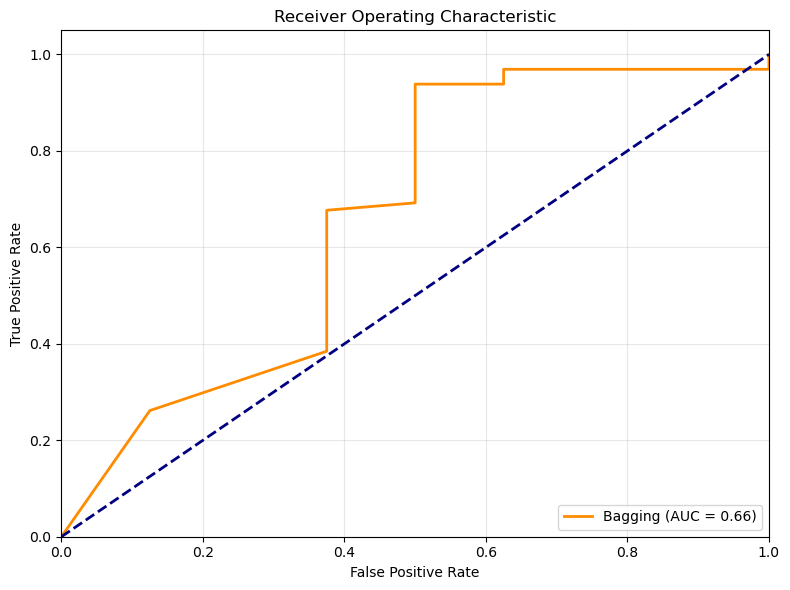

In [18]:
# Calculate and plot ROC curve
# Generate predictions and probability estimates
y_pred_proba = bagging_clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_bagging = auc(fpr, tpr)

# Plot ROC curve with AUC in the legend label
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f"Bagging (AUC = {roc_auc_bagging:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

*your anwer here*

### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [19]:
# Separate majority and minority classes

# Check class distribution
print("Original class distribution:")
print(y_train.value_counts())

# Determine which is the minority class
class_counts = y_train.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()

print(f"Minority class: {minority_class}, count: {class_counts[minority_class]}")
print(f"Majority class: {majority_class}, count: {class_counts[majority_class]}")

Original class distribution:
Subarid
1    152
0     17
Name: count, dtype: int64
Minority class: 0, count: 17
Majority class: 1, count: 152


In [20]:
# Separate X_train and y_train by class
X_majority = X_train[y_train == majority_class]
y_majority = y_train[y_train == majority_class]
X_minority = X_train[y_train == minority_class]
y_minority = y_train[y_train == minority_class]

print(f"X_majority shape: {X_majority.shape}")
print(f"X_minority shape: {X_minority.shape}")

X_majority shape: (152, 20)
X_minority shape: (17, 20)


In [21]:
# Upsample the minority class
X_minority_upsampled, y_minority_upsampled = resample(
    X_minority, 
    y_minority,
    replace=True,                  # Sample with replacement
    n_samples=len(X_majority),     # Match majority class size
    random_state=808               # Reproducible results
)

print(f"After upsampling - X_minority_upsampled shape: {X_minority_upsampled.shape}")

After upsampling - X_minority_upsampled shape: (152, 20)


In [22]:
# Combine majority and upsampled minority class
X_train_balanced = pd.concat([X_majority, X_minority_upsampled])
y_train_balanced = pd.concat([y_majority, y_minority_upsampled])

In [28]:
# Shuffle the dataset

# Print value counts 









# Step 4: Shuffle the resampled dataset
# Create a temporary dataframe to shuffle X and y together
temp_df = pd.concat([X_train_balanced, y_train_balanced], axis=1)
temp_df = temp_df.sample(frac=1, random_state=808)  # Shuffle

# Split back into X and y
X_train_balanced = temp_df.iloc[:, :-1]  # All columns except the last
y_train_balanced = temp_df.iloc[:, -1]   # Only the last column

# Step 5: Print the value counts to verify balance
print("\nClass distribution after upsampling:")
print(y_train_balanced.value_counts())

# Print the final shapes
print(f"\nFinal balanced training data:")
print(f"X_train_balanced shape: {X_train_balanced.shape}")
print(f"y_train_balanced shape: {y_train_balanced.shape}")

Original class distribution:
Subarid
1    152
0     17
Name: count, dtype: int64
Minority class: 0, count: 17
Majority class: 1, count: 152
X_majority shape: (152, 20)
X_minority shape: (17, 20)
After upsampling - X_minority_upsampled shape: (152, 20)

Class distribution after upsampling:
Subarid
0    152
1    152
Name: count, dtype: int64

Final balanced training data:
X_train_balanced shape: (304, 20)
y_train_balanced shape: (304,)


### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

*your answer here*

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

What features are most important in our model of species distribution?

*your answer here*